#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, 1 pst, X enzymes, one sample per instance, multiple enzymes per instance, test how many enzymes can have in one instances, how computing time depends on N p::f for 60 samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [3]:
# os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [4]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['p_occupancy']

,phosphosite,sample,value,prob
0,p0,s1,dec,0.534836
1,p0,s10,dec,0.886022
2,p0,s100,inc,0.939162
3,p0,s11,inc,0.629953
4,p0,s12,dec,0.624732
...,...,...,...,...
95,p0,s95,dec,0.711932
96,p0,s96,dec,0.913534
97,p0,s97,dec,0.845633
98,p0,s98,inc,0.887979


In [12]:
data['p_occupancy']['value'].value_counts()

inc     40
dec     36
base    24
Name: value, dtype: int64

In [15]:
data['e_activity']['value'].value_counts()

inc     109
dec     101
base     90
Name: value, dtype: int64

In [13]:
data['p_occupancy']['prob'] = np.where(data['p_occupancy']['value'] == 'base', 1 - data['p_occupancy']['prob'], data['p_occupancy']['prob'])
data['p_occupancy']['value'] = np.where(data['p_occupancy']['value'] == 'base', np.random.choice(['inc', 'dec'], size=len(data['p_occupancy']['value']), p=[0.5, 0.5]), data['p_occupancy']['value'])
data['p_occupancy']['value'].value_counts()

inc    53
dec    47
Name: value, dtype: int64

In [17]:
data['e_activity']['prob'] = np.where(data['e_activity']['value'] == 'base', 1 - data['e_activity']['prob'], data['e_activity']['prob'])
data['e_activity']['value'] = np.where(data['e_activity']['value'] == 'base', np.random.choice(['inc', 'dec'], size=len(data['e_activity']['value']), p=[0.5, 0.5]), data['e_activity']['value'])
data['e_activity']['value'].value_counts()

inc    160
dec    140
Name: value, dtype: int64

In [18]:
# duplicate data['p_occupancy'] * n and replace p0 in the new df with pn
# use pd.concat
n = 10 # doesn't work for n > 9 in samples where all phosphosites are base
new_occ = data['p_occupancy'].copy()
for i in range(1, n):
    new_phos = data['p_occupancy'].copy()
    new_phos['phosphosite'] = new_phos['phosphosite'].replace('p0', 'p' + str(i))
    new_occ = pd.concat([new_occ, new_phos], ignore_index=True)
new_occ

,phosphosite,sample,value,prob
0,p0,s1,dec,0.751050
1,p0,s10,dec,0.884666
2,p0,s100,inc,0.885386
3,p0,s11,inc,0.707411
4,p0,s12,dec,0.851823
...,...,...,...,...
995,p9,s95,dec,0.714859
996,p9,s96,dec,0.549454
997,p9,s97,dec,0.840331
998,p9,s98,inc,0.700061


Splitting data into training/testing

In [19]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.6))
print(train)
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = data['e_activity'][data['e_activity']['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = new_occ[new_occ['sample'].isin(train)].reset_index(drop=True)

['s34', 's33', 's72', 's79', 's77', 's75', 's99', 's2', 's5', 's44', 's89', 's28', 's100', 's16', 's58', 's65', 's17', 's54', 's63', 's18', 's84', 's35', 's73', 's95', 's30', 's6', 's68', 's70', 's71', 's39', 's66', 's94', 's20', 's91', 's81', 's31', 's69', 's82', 's50', 's86', 's22', 's1', 's3', 's25', 's85', 's90', 's64', 's96', 's27', 's9', 's23', 's78', 's98', 's32', 's4', 's53', 's29', 's51', 's87', 's14']


In [20]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [21]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
evidence_dict = {}
for s in samples:
    evidence = []
    for predicate in predicates:
        evid_generator = build.ProblogStatementGenerator(predicates[predicate])
        evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    evidence_dict[s] = evidence

In [22]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o7.pl', 'w') as f:
    for s in evidence_dict:
        for e in evidence_dict[s]:
            f.write(e + '\n')
        f.write('--------------------' + '\n')

LFI

In [25]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 5
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o7.pl {DIR}evidence_o7.pl -O {DIR}p_model_o7.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

[INFO] Output level: INFO
[INFO] Number of examples: 60
[INFO] Compile time: 12.890396
[INFO] Weights to learn: [t(0.33,E,S)::e_activity(E,S,dec), t(0.33,E,S)::e_activity(E,S,inc), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_inc(P,S), t(0.7,E,P)::occ_inc(P,S), t(1.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(1.0)::p_occupancy(P,S,inc), t(0.5)::p_occupancy(P,S,dec), t(0.5)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,inc)]
[INFO] Bodies: [lfi_body(0,t(E,S),E,S,dec), lfi_body(1,t(E,S),E,S,inc), lfi_body(2,t(E,P),P,S), lfi_body(3,t(E,P),P,S), lfi_body(4,t(E,P),P,S), lfi_body(5,t(E,P),P,S), lfi_body(6,t,P,S,dec), lfi_body(7,t,P,S,inc), lfi_body(8,t,P,S,dec), lfi_body(9,t,P,S,inc), lfi_body(10,t,P,S,dec), lfi_body(11,t,P,S,inc), lfi_body(12,t,P,S,dec), lfi_body(13,t,P,S,inc)]
[INFO] Parents: [lfi_par(0,t(E,S),E,S,dec), lfi_par(1,t(E,S),E,S,inc), lfi_par(2,t(E,P),P,S), lfi_par(3,t(E,P),P,S), lf

0

In [30]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o7.pl -o {DIR}p_model_o7_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s1)::e_activity(e1,s1,dec); t(0.33,e1,s1)::e_activity(e1,s1,inc).\n0.001::e_ksea(e1,s1,inc) :- e_activity(e1,s1,dec).\n0.6675::e_ksea(e1,s1,inc) :- e_activity(e1,s1,inc).\nt(0.33,e2,s1)::e_activity(e2,s1,dec); t(0.33,e2,s1)::e_activity(e2,s1,inc).\n0.9956::e_ksea(e2,s1,dec) :- e_activity(e2,s1,dec).\n0.001::e_ksea(e2,s1,dec) :- e_activity(e2,s1,inc).\nt(0.33,e3,s1)::e_activity(e3,s1,dec); t(0.33,e3,s1)::e_activity(e3,s1,inc).\n0.001::e_ksea(e3,s1,inc) :- e_activity(e3,s1,dec).\n0.9054::e_ksea(e3,s1,inc) :- e_activity(e3,s1,inc).\nt(0.7,e1,p0)::occ_dec(p0,s1) :- e_activity(e1,s1,dec).\nt(0.7,e2,p0)::occ_dec(p0,s1) :- e_activity(e2,s1,dec).\nt(0.7,e3,p0)::occ_dec(p0,s1) :- e_activity(e3,s1,inc).\nt(0.7,e1,p0)::occ_inc(p0,s1) :- e_activity(e1,s1,inc).\nt(0.7,e2,p0)::occ_inc(p0,s1) :- e_activity(e2,s1,inc).\nt(0.7,e3,p0)::occ_inc(p0,s1) :- e_activity(e3,s1,dec).\nt(1.0)::p_occupancy(p0,s1,dec); t(0.0)::p_occupancy(p0,s1,inc) :- occ_dec(p0,s1), \\+occ_inc(p0,s1).\nt(0.0)::

256

In [80]:
n_pst = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
n_pfacts = np.array([21, 33, 45, 57, 69, 81, 93, 105, 117])
n_pfacts_e = np.array([25, 38, 51, 64, 77, 90, 103, 116, 129])
n_params = np.array([28, 44, 60, 76, 92, 108, 124, 140, 156])
t_compile = np.array([2.146084, 3.695223, 4.946033, 6.129465, 7.162675, 8.631669, 9.583529, 10.892331, 12.147791])
t_total = np.array([5.8, 21.7, 39.8, 62.5, 92.7, 126.2, 165.7, 224.6, 276.9])

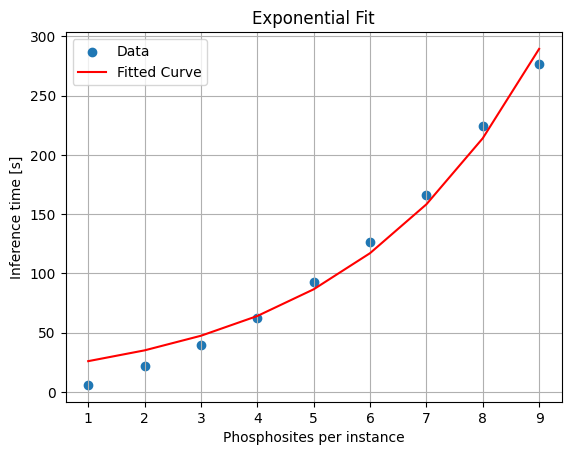

Predicted y-value for x = 10: 391.4373306497779s = 6.523955510829632min = 0.10873259184716053h


In [81]:
viz.plot_time_exp(n_pst, t_total, 'Phosphosites per instance', 'Inference time [s]', 10)

n_pfacts - Predicted y-value for x = 80: 114.09640763968729s = 1.901606793994788min = 0.031693446566579804h
n_pfacts_e - Predicted y-value for x = 80: 92.7555435353442s = 1.54592572558907min = 0.025765428759817834h
n_params - Predicted y-value for x = 80: 68.98363677785893s = 1.1497272796309823min = 0.01916212132718304h


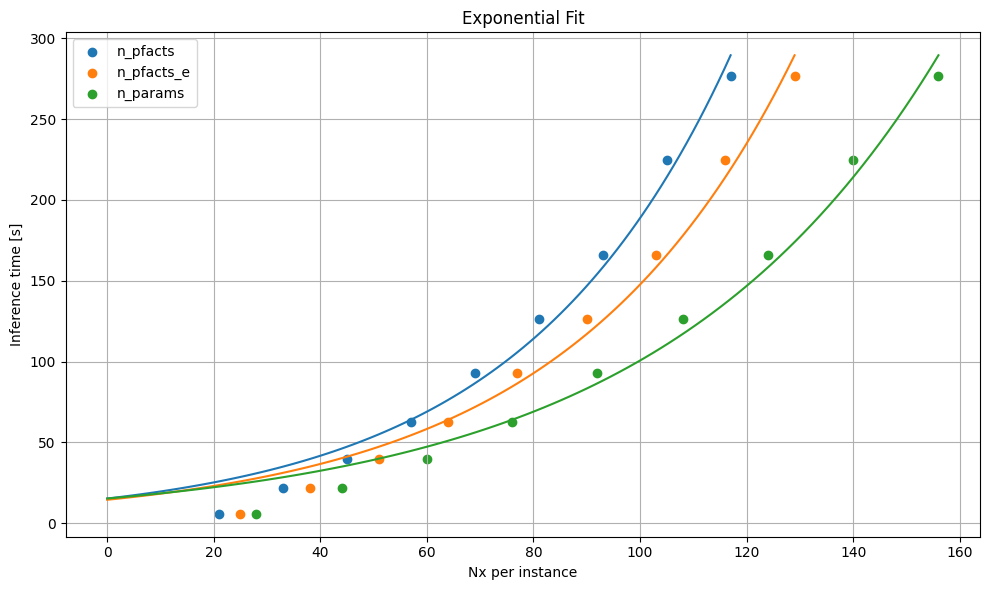

In [82]:
x_features = {'n_pfacts': n_pfacts, 'n_pfacts_e': n_pfacts_e, 'n_params': n_params}
y_time = {'n_pfacts': t_total, 'n_pfacts_e': t_total, 'n_params': t_total}
viz.plot_multiple_time_exp(x_features, y_time, 'Nx per instance', 'Inference time [s]', 80)

Compare with o3

In [88]:
n_pst_o3 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
n_pfacts_o3 = np.array([32, 52, 72, 92, 112, 132, 152, 172, 192])
n_pfacts_e_o3 = np.array([36, 57, 78, 99, 120, 141, 162, 183, 204])
n_params_o3 = np.array([54, 90, 126, 162, 198, 234, 270, 306, 342])
t_compile_o3 = np.array([4.609820, 10.074684, 14.038472, 18.286268, 21.350415, 24.614276])
t_total_o3 =  np.array([37.8, 381.5, 689.5, 893.9, 1012.0, 1379.2])

n_pst - Predicted y-value for x = 10: 391.4373306497779s = 6.523955510829632min = 0.10873259184716053h
n_pst_o3 - Predicted y-value for x = 10: 5064.831007102433s = 84.41385011837389min = 1.4068975019728982h


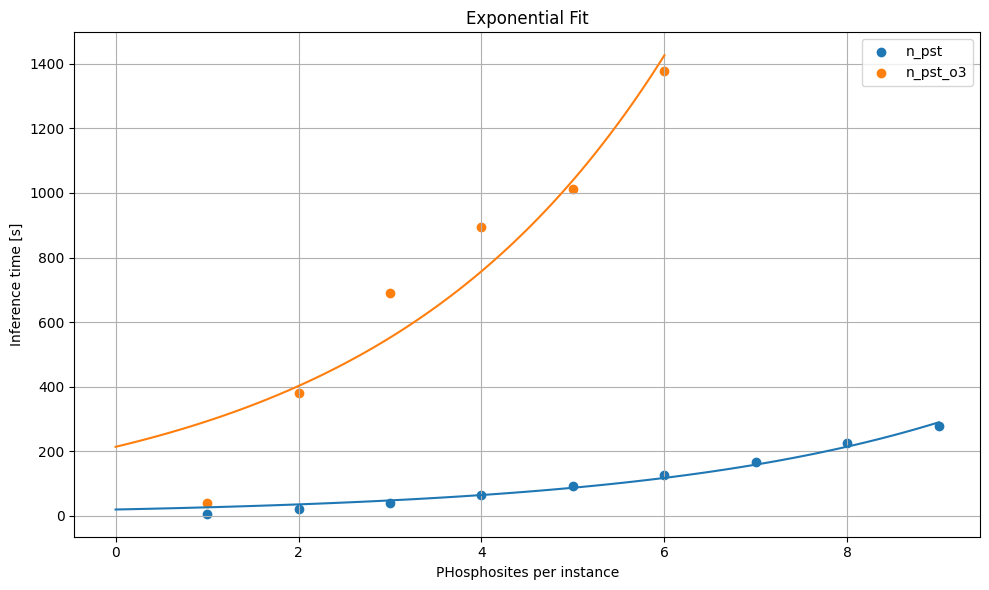

In [89]:
x_features = {'n_pst': n_pst, 'n_pst_o3': n_pst_o3[:6]}
y_time = {'n_pst': t_total, 'n_pst_o3': t_total_o3}
viz.plot_multiple_time_exp(x_features, y_time, 'PHosphosites per instance', 'Inference time [s]', 10)

n_pfacts - Predicted y-value for x = 60: 68.98353273240295s = 1.1497255455400492min = 0.019162092425667486h
n_pfacts_e - Predicted y-value for x = 60: 58.29389268715312s = 0.9715648781192187min = 0.016192747968653644h
n_params - Predicted y-value for x = 60: 47.29894026782805s = 0.7883156711304675min = 0.013138594518841125h
n_pfacts_o3 - Predicted y-value for x = 60: 456.2453094219531s = 7.604088490365885min = 0.12673480817276475h
n_pfacts_e_o3 - Predicted y-value for x = 60: 420.56131312619044s = 7.009355218769841min = 0.11682258697949735h
n_params_o3 - Predicted y-value for x = 60: 308.71385911935806s = 5.145230985322635min = 0.08575384975537724h


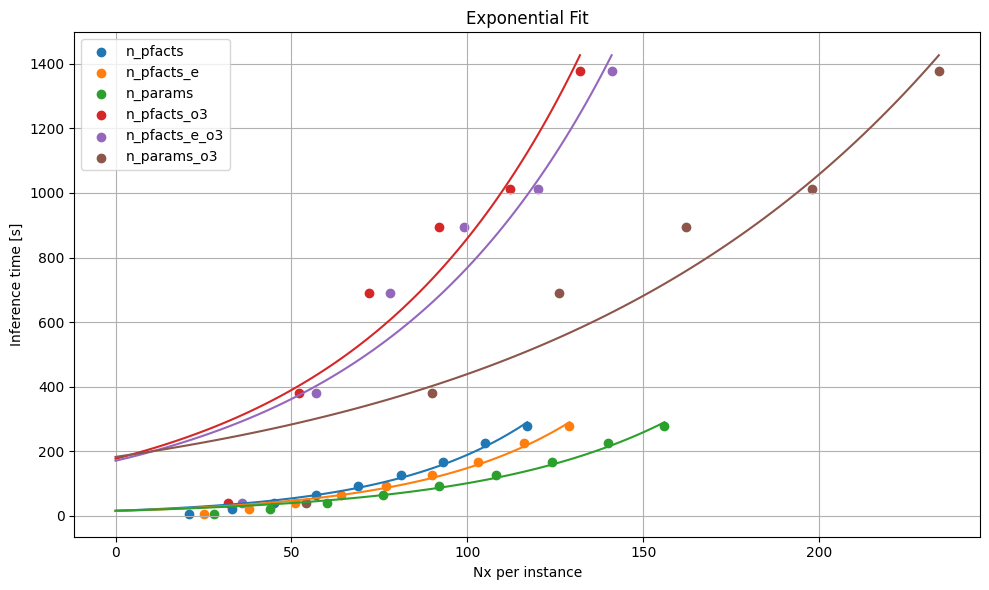

In [90]:
x_features = {'n_pfacts': n_pfacts, 'n_pfacts_e': n_pfacts_e, 'n_params': n_params,
              'n_pfacts_o3': n_pfacts_o3[:6], 'n_pfacts_e_o3': n_pfacts_e_o3[:6], 'n_params_o3': n_params_o3[:6]}
y_time = {'n_pfacts': t_total, 'n_pfacts_e': t_total, 'n_params': t_total,
          'n_pfacts_o3': t_total_o3, 'n_pfacts_e_o3': t_total_o3, 'n_params_o3': t_total_o3}
viz.plot_multiple_time_exp(x_features, y_time, 'Nx per instance', 'Inference time [s]', 60)

In [ ]:
# Where does the increase in time come from? Not the number of p::f, not the number of phosphosites because more psts in o7 at 80 e.g.
# Maybe the number of parameters independent of the number of p::f?